# Password Strength Classifier

The purpose of this model is to rate a password as being either strong, medium or weak. It will make these ratings using a MLP network trained using a vectorized dataset

## Preface: Meet the Dataset

The dataset for this project came from [Kaggle](https://www.kaggle.com/bhavikbb/password-strength-classifier-dataset), but it orignally appeared as part of the 000webhost data leak of over 3 million passwords. However, this dataset contains only around 670k entries.

Each password is labelled as either weak (0), medium (1), or strong (2). A tool from Georgia Tech University made these ratings based on the algorithms of commercial password meters. The dataset was reduced significantly due to the fact that only passwords that recieved the same label from ALL algorithms in the Georgia Tech toolchain remain.

It is worth noting that the dataset is strongly biased toward medium passwords, due to the fact that most people probably don't have very strong passwords...

## 1.0 Generate Features and Labels from Dataset

The CSV file may contain passwords that have commas as part of the string, so it must be parsed manually

In [17]:
path = 'data.csv'

# Import file
with open(path) as f:
    content = f.readlines()

# Remove header
content.pop(0)

features = []
labels = []
for line in content:
    # Contains everything up to (but not including) the comma
    feat = line[:-3]
    # Just the rating
    lab = int(line[-2])

    features.append(feat)
    labels.append(lab)

## 2.0 Vectorize Features

The only feature in this dataset is the password itself. In order to extract meaningful information from this feature, each password will be converted into a vector.

This process involves assigning an integer to each character that appears in the feature space. Here, we will use the TF-IDF algorithim, This vectorizer counts the term frequency, or how many times each character appears in the password. After, it will find how many times the character appears in the entire dataset (document frequency) and take its inverse. These metrics create additional features that represent the impact of certain characters or sequences of characters in making a strong password

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

class Vectorizer:
    def __init__(self, text):
        self.vectorizer = TfidfVectorizer(tokenizer=self.tokenize)
        self.vectorizer.fit(text)

    def encode(self, text):
        return self.vectorizer.transform(text)

    def tokenize(self, word):
      chars = []
      for i in word:
        chars.append(i)
      return chars

    def export(self, filename):
      with open(filename, 'wb') as file:
        pickle.dump(self.vectorizer, file)

    @property
    def vocabulary(self):
      return self.vectorizer.vocabulary_

In [19]:
vectorizer = Vectorizer(features)
x = vectorizer.encode(features)
y = labels

# Cleanup
del features
del labels

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### 2.1 Explore Vectorizer

In [20]:
print("VOCABULARY")
print(vectorizer.vocabulary)
print("=======================================================================")
print("\nEXAMPLE ENTRY")
print("  CHAR CODE\tTF-IDF Score")
print(x[500])

VOCABULARY
{'k': 67, 'z': 82, 'd': 60, 'e': 61, '5': 40, '7': 42, 'i': 65, 'n': 70, 'o': 71, '3': 38, '4': 39, 'v': 78, 's': 75, '1': 36, 'y': 81, 'r': 74, 'm': 69, 'g': 63, '2': 37, 'l': 68, 'a': 57, 'b': 58, 'h': 64, 'q': 73, 'f': 62, 't': 76, 'u': 77, '6': 41, 'c': 59, '8': 43, 'w': 79, '9': 44, '0': 35, 'j': 66, 'p': 72, '@': 50, '-': 32, 'x': 80, '.': 33, '>': 48, '&': 26, '?': 49, '<': 46, '!': 21, ';': 45, '_': 55, '%': 25, '±': 100, '"': 22, '~': 86, '+': 30, '^': 54, '/': 34, '$': 24, ')': 28, ' ': 20, '(': 27, '#': 23, ',': 31, 'ú': 139, '*': 29, '`': 56, '{': 83, '}': 85, '[': 51, ']': 53, 'þ': 143, 'ó': 133, 'ô': 134, '=': 47, '\\': 52, '\x1c': 17, '³': 102, '¿': 113, '\x16': 12, 'ò': 132, '·': 106, '\x1e': 19, '\x19': 15, '\x05': 3, '\x1b': 16, 'å': 121, '‚': 148, 'ä': 120, 'à': 116, 'õ': 135, 'ß': 115, '´': 103, '«': 97, 'ð': 130, 'â': 118, '°': 99, '|': 84, '\x7f': 87, '²': 101, '¾': 112, 'ÿ': 144, '\x08': 5, 'ê': 126, 'á': 117, '\x10': 8, '\x17': 13, 'º': 108, '¡': 91, 

### 2.2 Export Vectorizer
This will be useful later for vectorizing user input

In [21]:
vectorizer.export('vectorizer.pkl')

## 3.0 Prepare Data for Training

As one does

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

## 4.0 Train a Variety of Models to Asses Password Strength

### 4.1 Multi-Layer Perceptron Classifier

The main reason to dry a deep neural network first is because it is difficult to identify meaningful relationships between word vectors. Individual character counts are not inherently useful, and the random nature of passwords means that there are not likely to be obvious patterns. It will probably be best to allow an MLPC to extract correlations from the vectorization. Let's try a couple of different configurations until we like the results

In [39]:
from sklearn.neural_network import MLPClassifier

#( (100,), 480, 1e-4, 10, 1e-4, 1, 0.1):  min_loss=0.3227@i=12
#( (100,), 480, 1e-4, 10, 1e-4, 1, 0.01): min_loss=0.0959@i=17
#( (150,), 480, 1e-4, 10, 1e-4, 1, 0.01): min_loss=0.0674@i=20
#( (300,), 480, 1e-4, 10, 1e-4, 1, 0.01): min_loss=0.0638@i=14
mlpc = MLPClassifier(hidden_layer_sizes=(500, ), max_iter=480, alpha=1e-4, \
                     verbose=10, tol=1e-4, random_state=1, \
                     learning_rate_init=.01).fit(x_train, y_train)

Iteration 1, loss = 0.32730097
Iteration 2, loss = 0.15563872
Iteration 3, loss = 0.10505640
Iteration 4, loss = 0.08861558
Iteration 5, loss = 0.08024116
Iteration 6, loss = 0.07518043
Iteration 7, loss = 0.07226408
Iteration 8, loss = 0.06894647
Iteration 9, loss = 0.06624395
Iteration 10, loss = 0.06292858
Iteration 11, loss = 0.06093834
Iteration 12, loss = 0.06022469
Iteration 13, loss = 0.05858160
Iteration 14, loss = 0.05673119
Iteration 15, loss = 0.05604892
Iteration 16, loss = 0.05496281
Iteration 17, loss = 0.05456942
Iteration 18, loss = 0.05446240
Iteration 19, loss = 0.05219533
Iteration 20, loss = 0.05220947
Iteration 21, loss = 0.05115313
Iteration 22, loss = 0.05066691
Iteration 23, loss = 0.04984197
Iteration 24, loss = 0.04932942
Iteration 25, loss = 0.04839533
Iteration 26, loss = 0.04916089
Iteration 27, loss = 0.04771609
Iteration 28, loss = 0.04738859
Iteration 29, loss = 0.04764739
Iteration 30, loss = 0.04709914
Iteration 31, loss = 0.04705092
Iteration 32, los

#### 4.1.1 That Took Forever... Let's Save the Model
The MLPC model took about four hours to converge. Fortunately, the training went uninterrupted, but it would be a good idea to save the model ever 10 iterations as a fail-safe. For now, we will just export the final model

In [41]:
import pickle

pkl_filename = 'pwd_strength-mlpc-300layer-0.01dt.pkl'

with open(pkl_filename, 'wb') as file:
  pickle.dump(mlpc, file)

#### 4.1.2 Evaluate MLPC Model

After all of that time it took to train, it will be exciting to see how it performs

F1 Score: 0.988789


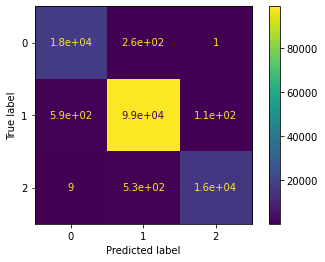

In [42]:
from sklearn.metrics import f1_score, plot_confusion_matrix
import matplotlib.pyplot as plt

# Calculate F1
y_pred = mlpc.predict(x_test)
f1 = f1_score(y_test, y_pred, average='micro')

print('F1 Score: %f' % f1)

# Show multi-class confusion matrix
cm = plot_confusion_matrix(mlpc, x_test, y_test)
plt.show(cm)

The F1 score for this model is very high, which is promising. This hopefully means that it is not overfit to the dataset. Looking at the confusion matrix, it performs quite well. There are MANY more medium passwords than weak or strong, but this is to be expected, as the distribution of the original dataset leads toward medium passwords. At any rate, the number of incorrectly labelled passwords is low in comparison.

### 4.2 Logistic Regression
It may also be worthwhile to explore some less complex models too

In [12]:
from sklearn.linear_model import LogisticRegression as logReg

lrc = logReg(max_iter=10000, random_state=1, verbose=1).fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


#### 4.2.1 Evaluate Logistic Regression Classifier
That one trained over 100x faster than the MLPC. Let's see how its performance compares

F1 Score: 0.818617


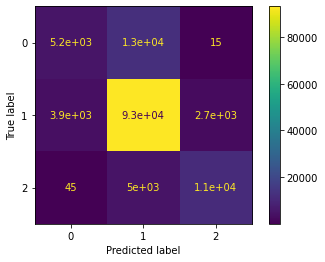

In [14]:
from sklearn.metrics import f1_score, plot_confusion_matrix
import matplotlib.pyplot as plt

# Calculate F1
y_pred = lrc.predict(x_test)
f1 = f1_score(y_test, y_pred, average='micro')

print('F1 Score: %f' % f1)

# Show multi-class confusion matrix
cm = plot_confusion_matrix(lrc, x_test, y_test)
plt.show(cm)

It looks like the MLPC model wins!